# General rundown
This notebook details the construction of the $C_\ell$ data vector for use in the main analysis, as well as the construction of the derivative vectors with respect to each cosmological parameter. Intitial forecasting is then done using the chainconsumer python library (big triangle plots)

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt

In [2]:
params_fiducial_test = {'Omega_c': 0.27,\
                           'Omega_b': 0.045,\
                           'h': 0.67,\
                           'A_s_norm': 2.1,\
                           'n_s': 0.96,\
                           'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
                           'w0': -0.9,\
                           'wa': 0,\
                           'mu_0': 0,\
                           'sigma_0': 0 }

In [3]:
def data_vector(params):
    '''This function takes a parameter argument which is a list of dictionaries used to vary one specific parameter,
    it then calculates the data vectors for each dict and plots them on the same matplotlib figure, allowing for the
    effects of varying each cosmological parameter on the data vectors form to be analysed'''
    
    cosmo = ccl.Cosmology(Omega_c = params['Omega_c'],\
                          Omega_b = params['Omega_b'],\
                          h = params['h'],\
                          A_s = params['A_s_norm']*10**(-9),\
                          n_s = params['n_s'],\
                          w0 = params['w0'],\
                          wa = params['wa'],\
                          mu_0 = params['mu_0'],\
                          sigma_0 = params['sigma_0'],\
                          matter_power_spectrum = 'linear')
    
    #Load in lensing and clustering distributions and ell
    dNdz_lens = np.loadtxt('dNdz_srcs_LSSTSRD_Y1.dat') 
    dNdz_clust = np.loadtxt('dNdz_clust_LSSTSRD_Y1.dat')
    ell = np.loadtxt('ell-values')
    
    #Construct tracer objects
    tracers_clust = []
    tracers_lens = []
    
    for i in range(5):
        tracers_clust.append(ccl.NumberCountsTracer(cosmo,\
                                                    has_rsd=False,\
                                                    dndz=(dNdz_clust[:,0],\
                                                    dNdz_clust[:,i+1]),\
                                                    bias=(dNdz_clust[:,0], params['bias'][i]*np.ones(2000))))
    
        tracers_lens.append(ccl.WeakLensingTracer(cosmo, dndz=(dNdz_lens[:,0], dNdz_lens[:,i+1])))
    
    #Now that the tracers are constructed, calculate C_l's for clustering, gg-lensing and shear
    cls_clus = []
    cls_gg = []
    cls_gg_clean = []
    gglensing = [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
    cls_lens = []
    

    for i in range(len(tracers_clust)):
        
        cls_clus.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_clust[i], ell))
        
        for j in range(len(tracers_clust)):
            
            cls_gg.append(ccl.angular_cl(cosmo, tracers_clust[i], tracers_lens[j], ell))
            
            if i >= j:
                cls_lens.append(ccl.angular_cl(cosmo,tracers_lens[i], tracers_lens[j], ell))
                
    for n in range(len(gglensing)):
        if gglensing[n] == 1:
            cls_gg_clean.append(cls_gg[n])

    #Clean up the data vectors shapes and combine them all
    cls_lens = np.append(cls_lens, cls_gg_clean)
    cls_combined = np.append(cls_lens, cls_clus)
    
    return cls_combined

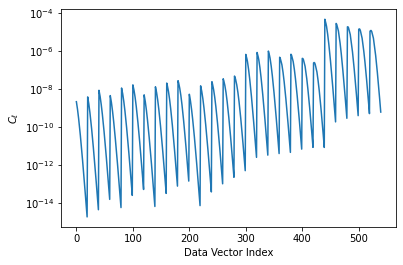

In [4]:
#Check that the data vector is looking as it should be (in comparison to the LSST one)

data_vector_fiducial = data_vector(params_fiducial_test)

plt.plot(data_vector_fiducial)
plt.yscale('log')
plt.ylabel('$C_\ell$')
plt.xlabel('Data Vector Index')
plt.show()

### Finite difference method to calculate the numerical derivative data vectors (should be 540 long)

In [5]:
def numerical_deriv(param,h):
    '''This function takes a parameter "param" and a value for h to calculate the numerical derivative with respect to param of
    each index of the c_ell value data vector. Note - h is as a percentage of the fiducial value of the parameter "param".
    This is done through the use of the 5 point finite difference method. This function only takes inputs of a string for 
    "param" and a positive value of h.'''
    if type(param) != str:
        print('Please input a parameter name as a string')

    if h <= 0:
        print('Please input a positive value for h')
        
    #Define the fiducial parameters for the model that will be varied by h%
    #Since the values for mu0 sig0 and wa are 0 initially, set these to some small values to allow for the
    #derivative function to work properly 
    if param == 'mu_0' or param == 'sigma_0' or param == 'wa':
        params_fiducial = {'Omega_c': 0.27,\
                            'Omega_b': 0.045,\
                            'h': 0.67,\
                            'A_s_norm': 2.1,\
                            'n_s': 0.96,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': -0.9,\
                            'wa': 0.1,\
                            'mu_0': 0.1,\
                            'sigma_0': 0.1 }
    else:
        params_fiducial = {'Omega_c': 0.27,\
                            'Omega_b': 0.045,\
                            'h': 0.67,\
                            'A_s_norm': 2.1,\
                            'n_s': 0.96,\
                            'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                            'w0': -0.9,\
                            'wa': 0.0,\
                            'mu_0': 0.0,\
                            'sigma_0': 0.0 }

    #Create a dictionary list that varies the specified parameter by -2h,-h,h,2h
    
    params_pos2h  = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    
    params_posh = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    
    params_negh = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    
    params_neg2h = {'Omega_c': 0.27,\
                        'Omega_b': 0.045,\
                        'h': 0.67,\
                        'A_s_norm': 2.1,\
                        'n_s': 0.96,\
                        'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.293210],\
                        'w0': -0.9,\
                        'wa': 0.0,\
                        'mu_0': 0,\
                        'sigma_0': 0 }
    if param == 'bias_1':
        params_pos2h['bias'][0] += 2*h*params_fiducial['bias'][0]
        
        params_posh['bias'][0] += h*params_fiducial['bias'][0]
        
        params_negh['bias'][0] -= h*params_fiducial['bias'][0]
        
        params_neg2h['bias'][0] -= 2*h*params_fiducial['bias'][0]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['bias'][0]))
        
    elif param == 'bias_2':
        params_pos2h['bias'][1] += 2*h*params_fiducial['bias'][1]
        
        params_posh['bias'][1] += h*params_fiducial['bias'][1]
        
        params_negh['bias'][1] -= h*params_fiducial['bias'][1]
        
        params_neg2h['bias'][1] -= 2*h*params_fiducial['bias'][1]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['bias'][1]))
        
    elif param == 'bias_3':
        params_pos2h['bias'][2] += 2*h*params_fiducial['bias'][2]
        
        params_posh['bias'][2] += h*params_fiducial['bias'][2]
        
        params_negh['bias'][2] -= h*params_fiducial['bias'][2]
        
        params_neg2h['bias'][2] -= 2*h*params_fiducial['bias'][2]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['bias'][2]))
        
    elif param == 'bias_4':
        params_pos2h['bias'][3] += 2*h*params_fiducial['bias'][3]
        
        params_posh['bias'][3] += h*params_fiducial['bias'][3]
        
        params_negh['bias'][3] -= h*params_fiducial['bias'][3]
        
        params_neg2h['bias'][3] -= 2*h*params_fiducial['bias'][3]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['bias'][3]))
        
    elif param == 'bias_5':
        params_pos2h['bias'][4] += 2*h*params_fiducial['bias'][4]
        
        params_posh['bias'][4] += h*params_fiducial['bias'][4]
        
        params_negh['bias'][4] -= h*params_fiducial['bias'][4]
        
        params_neg2h['bias'][4] -= 2*h*params_fiducial['bias'][4]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                              + 8*data_vector(params_posh)\
                              - 8*data_vector(params_negh)\
                              + data_vector(params_neg2h))/(12*h*params_fiducial['bias'][4]))
    
    
    else:
        params_pos2h[f"{param}"] += 2*h*params_fiducial[f"{param}"]
    
        params_posh[f"{param}"] += h*params_fiducial[f"{param}"]
    
        params_negh[f"{param}"] -= h*params_fiducial[f"{param}"]
    
        params_neg2h[f"{param}"] -= 2*h*params_fiducial[f"{param}"]
        
        parameter_deriv_vector = ((-data_vector(params_pos2h)\
                                  + 8*data_vector(params_posh)\
                                  - 8*data_vector(params_negh)\
                                  + data_vector(params_neg2h))/(12*h*params_fiducial[f"{param}"]))
        
    print(params_pos2h)
    print(params_posh)
    print(params_neg2h)
    print(params_negh)


    return parameter_deriv_vector

{'Omega_c': 0.27540000000000003, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.2727, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.2646, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.26730000000000004, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


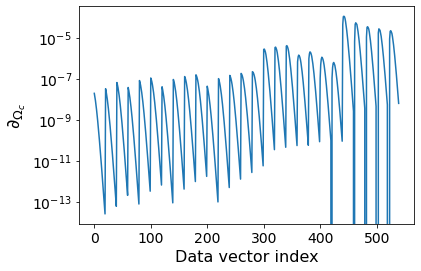

In [6]:
Omega_c_deriv = numerical_deriv('Omega_c', 0.01)

plt.plot(Omega_c_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{\Omega_c}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0.0002}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0.0001}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': -0.0002}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': -0.0001}


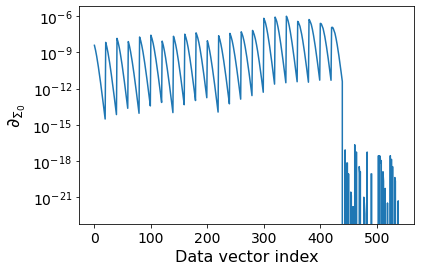

In [7]:
sig_0_deriv = numerical_deriv('sigma_0', 0.001)

plt.plot(sig_0_deriv)
plt.plot()
plt.yscale('log')
plt.ylabel('$\partial_{\Sigma_0}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.04509, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.04491, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.044954999999999995, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


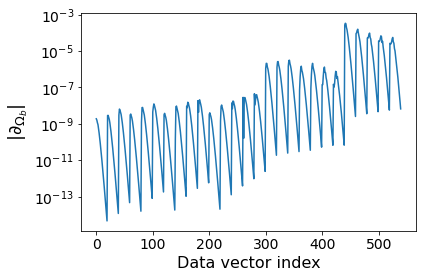

In [8]:
Omega_b_deriv = numerical_deriv('Omega_b', 0.001)

plt.plot(np.abs(Omega_b_deriv))
plt.yscale('log')
plt.ylabel('$|\partial_{\Omega_b}|$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0.0002, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0.0001, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': -0.0002, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': -0.0001, 'sigma_0': 0}


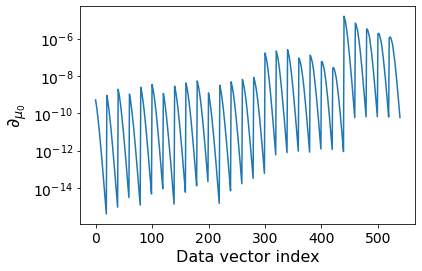

In [9]:
mu_0_deriv= numerical_deriv('mu_0', 0.001)

plt.plot(mu_0_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{\mu_0}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67134, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67067, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.66866, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.6693300000000001, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


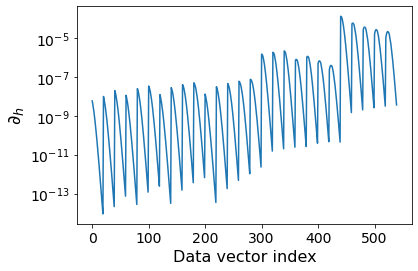

In [10]:
h_deriv = numerical_deriv('h', 0.001)

plt.plot(h_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{h}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1042, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1021, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.0958, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.0979, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


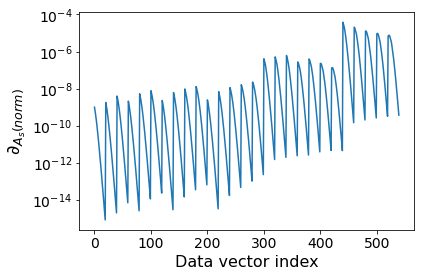

In [11]:
A_s_norm_deriv = numerical_deriv('A_s_norm', 0.001 )

plt.plot(A_s_norm_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{A_s(norm)}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9018, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9009, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.8982, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.8991, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


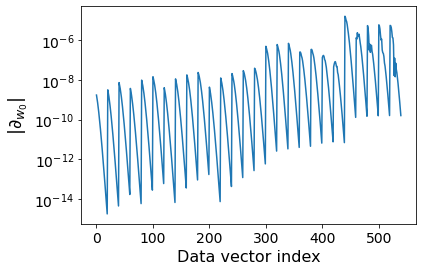

In [12]:
w0_deriv = numerical_deriv('w0', 0.001)

plt.plot(np.abs(w0_deriv))
plt.yscale('log')
plt.ylabel('$|\partial_{w_0}|$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0002, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0001, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': -0.0002, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': -0.0001, 'mu_0': 0, 'sigma_0': 0}


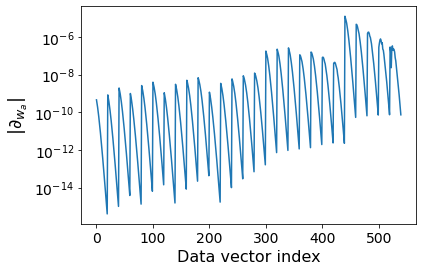

In [13]:
wa_deriv = numerical_deriv('wa', 0.001)

plt.plot(np.abs(wa_deriv))
plt.yscale('log')
plt.ylabel('$|\partial_{w_a}|$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96192, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.9609599999999999, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.9580799999999999, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.95904, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


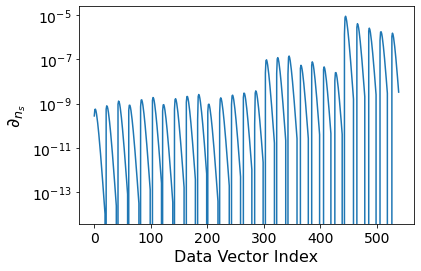

In [14]:
n_s_deriv = numerical_deriv('n_s', 0.001)

plt.plot(n_s_deriv)
plt.xlabel('Data Vector Index', fontsize = 16)
plt.ylabel('$\partial_{n_s}$', fontsize = 18)
plt.yscale('log')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.565486724, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.563924362, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.559237276, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.560799638, 1.732963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


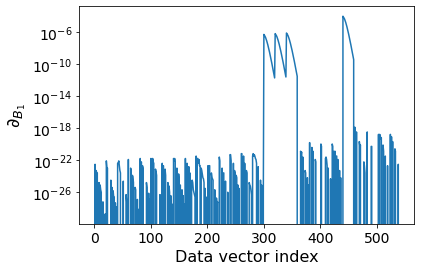

In [15]:
bias_1_deriv = numerical_deriv('bias_1', 0.001)

plt.plot(bias_1_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_1}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.736428926, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.734695963, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.729497074, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.731230037, 1.913252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


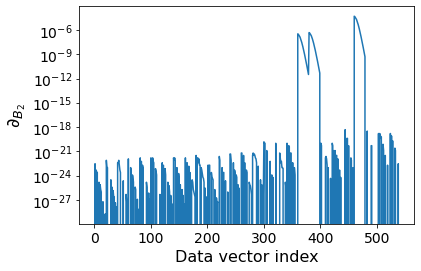

In [16]:
bias_2_deriv = numerical_deriv('bias_2', 0.001)

plt.plot(bias_2_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_2}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.917078504, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.915165252, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.9094254959999999, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.911338748, 2.100644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


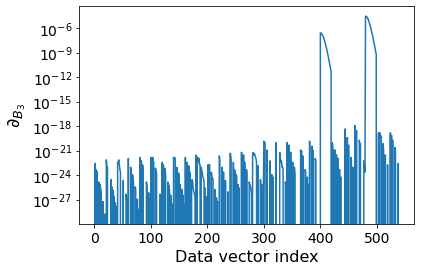

In [17]:
bias_3_deriv = numerical_deriv('bias_3', 0.001)

plt.plot(bias_3_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_3}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.104845288, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.102744644, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.096442712, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.098543356, 2.29321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


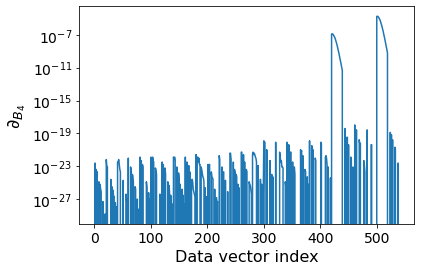

In [18]:
bias_4_deriv = numerical_deriv('bias_4', 0.001)

plt.plot(bias_4_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_4}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29779642], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.29550321], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.2886235800000003], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}
{'Omega_c': 0.27, 'Omega_b': 0.045, 'h': 0.67, 'A_s_norm': 2.1, 'n_s': 0.96, 'bias': [1.562362, 1.732963, 1.913252, 2.100644, 2.2909167900000003], 'w0': -0.9, 'wa': 0.0, 'mu_0': 0, 'sigma_0': 0}


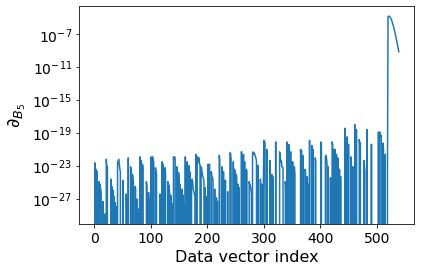

In [19]:
bias_5_deriv = numerical_deriv('bias_5', 0.001)

plt.plot(bias_5_deriv)
plt.yscale('log')
plt.ylabel('$\partial_{B_5}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14)
plt.show()

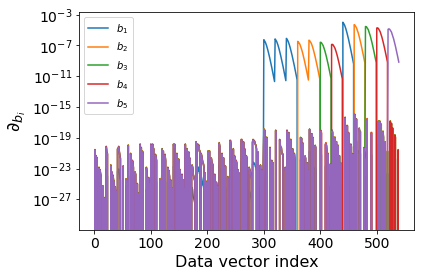

In [23]:
plt.plot(bias_1_deriv, label = '$b_1$')
plt.plot(bias_2_deriv, label = '$b_2$')
plt.plot(bias_3_deriv, label = '$b_3$')
plt.plot(bias_4_deriv, label = '$b_4$')
plt.plot(bias_5_deriv, label = '$b_5$')

plt.yscale('log')
plt.ylabel('$\partial_{b_i}$', fontsize = 18)
plt.xlabel('Data vector index', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend()

plt.show()

# Start on Fisher matrix calculation
### Load in covariance matrix, multiply deriv by inv cov by deriv
#### Note : (omeg_c, omeg_b, h, sig8, n_s, bias, sig0, mu0, w0l, w_a) is order we will be constructing this in

In [66]:
inv_cov = np.loadtxt('inv_cov_matrix') #read in the saved inverse covariance matrix
mask = np.loadtxt('scale_mask')
print(np.shape(mask))
print(np.shape(inv_cov))
print(inv_cov)

(705,)
(540, 540)
[[ 5.93063017e+18 -2.97754813e+16 -4.66205760e+16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.97754813e+16  1.27555122e+19 -7.41638895e+16 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.66205760e+16 -7.41638895e+16  2.70979734e+19 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


In [67]:
#initialise a numpy array for our fisher matrices for h = 10^-2 and the LSST fisher matrix
fisher = np.zeros(shape = (14,14))

fisher_LSST_Y1 = np.array([[4.321685e+05, 2.754616e+05, 5.992140e+04, -1.992358e+04, -4.473057e+03, -2.164983e+05, 5.264462e+04],
[2.754616e+05, 2.082198e+05, 2.691262e+04, -1.379929e+04, -3.407022e+03, -7.745383e+04, 1.946493e+04],
[5.992140e+04, 2.691262e+04, 2.414847e+04, -6.937346e+02, -1.056892e+02, -6.207807e+04, 1.576508e+04],
[-1.992358e+04, -1.379929e+04, -6.937346e+02, 1.395740e+03, 3.162361e+02, 4.976017e+03, -1.248729e+03],
[-4.473057e+03, -3.407022e+03, -1.056892e+02, 3.162361e+02, 8.081758e+01, 9.051103e+02, -2.218407e+02],
[-2.164983e+05, -7.745383e+04, -6.207807e+04, 4.976017e+03, 9.051103e+02, 3.877220e+05, -6.499201e+04],
[5.264462e+04, 1.946493e+04, 1.576508e+04, -1.248729e+03, -2.218407e+02, -6.499201e+04, 1.565908e+04]])

In [68]:
#Construct a dictionary that we can iterate through that contains our derivative data vectors
derivatives = [Omega_c_deriv,\
               Omega_b_deriv,\
               h_deriv,\
               A_s_norm_deriv,\
               n_s_deriv,\
               bias_1_deriv,\
               bias_2_deriv,\
               bias_3_deriv,\
               bias_4_deriv,\
               bias_5_deriv,\
               sig_0_deriv,\
               mu_0_deriv,\
               w0_deriv,\
               wa_deriv]

In [70]:
#apply mask to derivative vector (cuts down certain scales)
for i in range(len(derivatives)):
    for j in range(540):
        derivatives[i][j] = derivatives[i][j]*mask[j]

In [71]:
#Script to construct the fisher matrix, looping over the parameter derivatives

for i in range(len(derivatives)):
    for j in range(len(derivatives)):
        fisher[i][j] = np.matmul(derivatives[i], (np.matmul(inv_cov, derivatives[j])))

In [72]:
print(np.shape(fisher))
print(np.shape(fisher_LSST_Y1))

(14, 14)
(7, 7)


In [73]:
#eliminate rows and columns associated with modified gravity parameters in the fisher matrix 
#(treating the two as constant essentially) store in a new variable

fisher_no_mg = np.delete(fisher, 10, 0)
fisher_no_mg = np.delete(fisher_no_mg, 10, 1)
fisher_no_mg = np.delete(fisher_no_mg, 10, 0)
fisher_no_mg = np.delete(fisher_no_mg, 10, 1)


print(np.shape(fisher_no_mg))

(12, 12)


In [74]:
#1 sigma standard deviations between for each parameter in the original fisher matrix
sig_1_dev = []
for i in range(14):
    sig_1_dev.append((np.sqrt(fisher[i][i]))**(-1))
    
print(sig_1_dev)

[0.0004232602372482041, 0.0004339940762982097, 0.0008100318424399838, 0.005633537049438367, 0.0027171553139528144, 0.00968900592047576, 0.00760325847404763, 0.006533098252034653, 0.00702097953293934, 0.006083337471745189, 0.0030758975856926734, 0.019190669939833337, 0.00411763551924129, 0.01426531558387697]


In [75]:
#parameter covariance matrix is inverse of the fisher matrix so calculate parameter covariances for each fisher
param_cov = np.linalg.inv(fisher)

param_cov_LSST_Y1 = np.linalg.inv(fisher_LSST_Y1)

param_cov_no_mg = np.linalg.inv(fisher_no_mg)

In [76]:
#check that the standard deviations are all positive in the regular parameter covariance matrix
pos_or_neg = []

for i in range(8):
    if param_cov[i][i] < 0:
        pos_or_neg.append('neg')
    else:
        pos_or_neg.append('pos')
        
print(pos_or_neg)

['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos']


In [77]:
print(np.linalg.eig(param_cov)[0]) #ensure that all eigenvalues of the parameter covariance matrix are positive

[1.13826663e+01 2.03852315e+00 1.27460681e-01 1.90748848e-02
 2.76799410e-03 9.28737163e-04 2.19502205e-04 8.60296991e-05
 8.92836985e-08 6.58276691e-07 1.99110051e-05 5.51097392e-05
 3.88406146e-05 4.54503822e-05]


In [78]:
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist

In [79]:
#params_fiducial = {'Omega_c': 0.27,\
 #                          'Omega_b': 0.045,\
  #                         'h': 0.67,\
   #                        'A_s_norm': 2.1,\
    #                       'n_s': 0.96,\
     #                      'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
      #                     'w0': -0.9,\
        #                   'mu_0': 0,\
       #                    'sigma_0': 0 }

param_mean = [0.27, 0.045, 0.67, 2.1, 0.96, 1.562362, 1.732963, 1.913252, 2.100644, 2.293210, 0, 0, -0.9, 0.0]


param_names = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s', 'B1', 'B2', 'B3', 'B4', 'B5,' 'Sigma_0', 'mu_0', 'w0', 'wa']

labels = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'B^{1}', r'B^{2}', r'B^{3}', r'B^{4}', r'B^{5}', r'\Sigma_{0}', r'\mu_{0}', r'w_{0}', r'w_{a}']


gauss = GaussianND(param_mean, param_cov, labels = labels, names = param_names)

In [80]:
g = plots.get_subplot_plotter() #subplotter instance for chainconsumer (used for triangle plots)

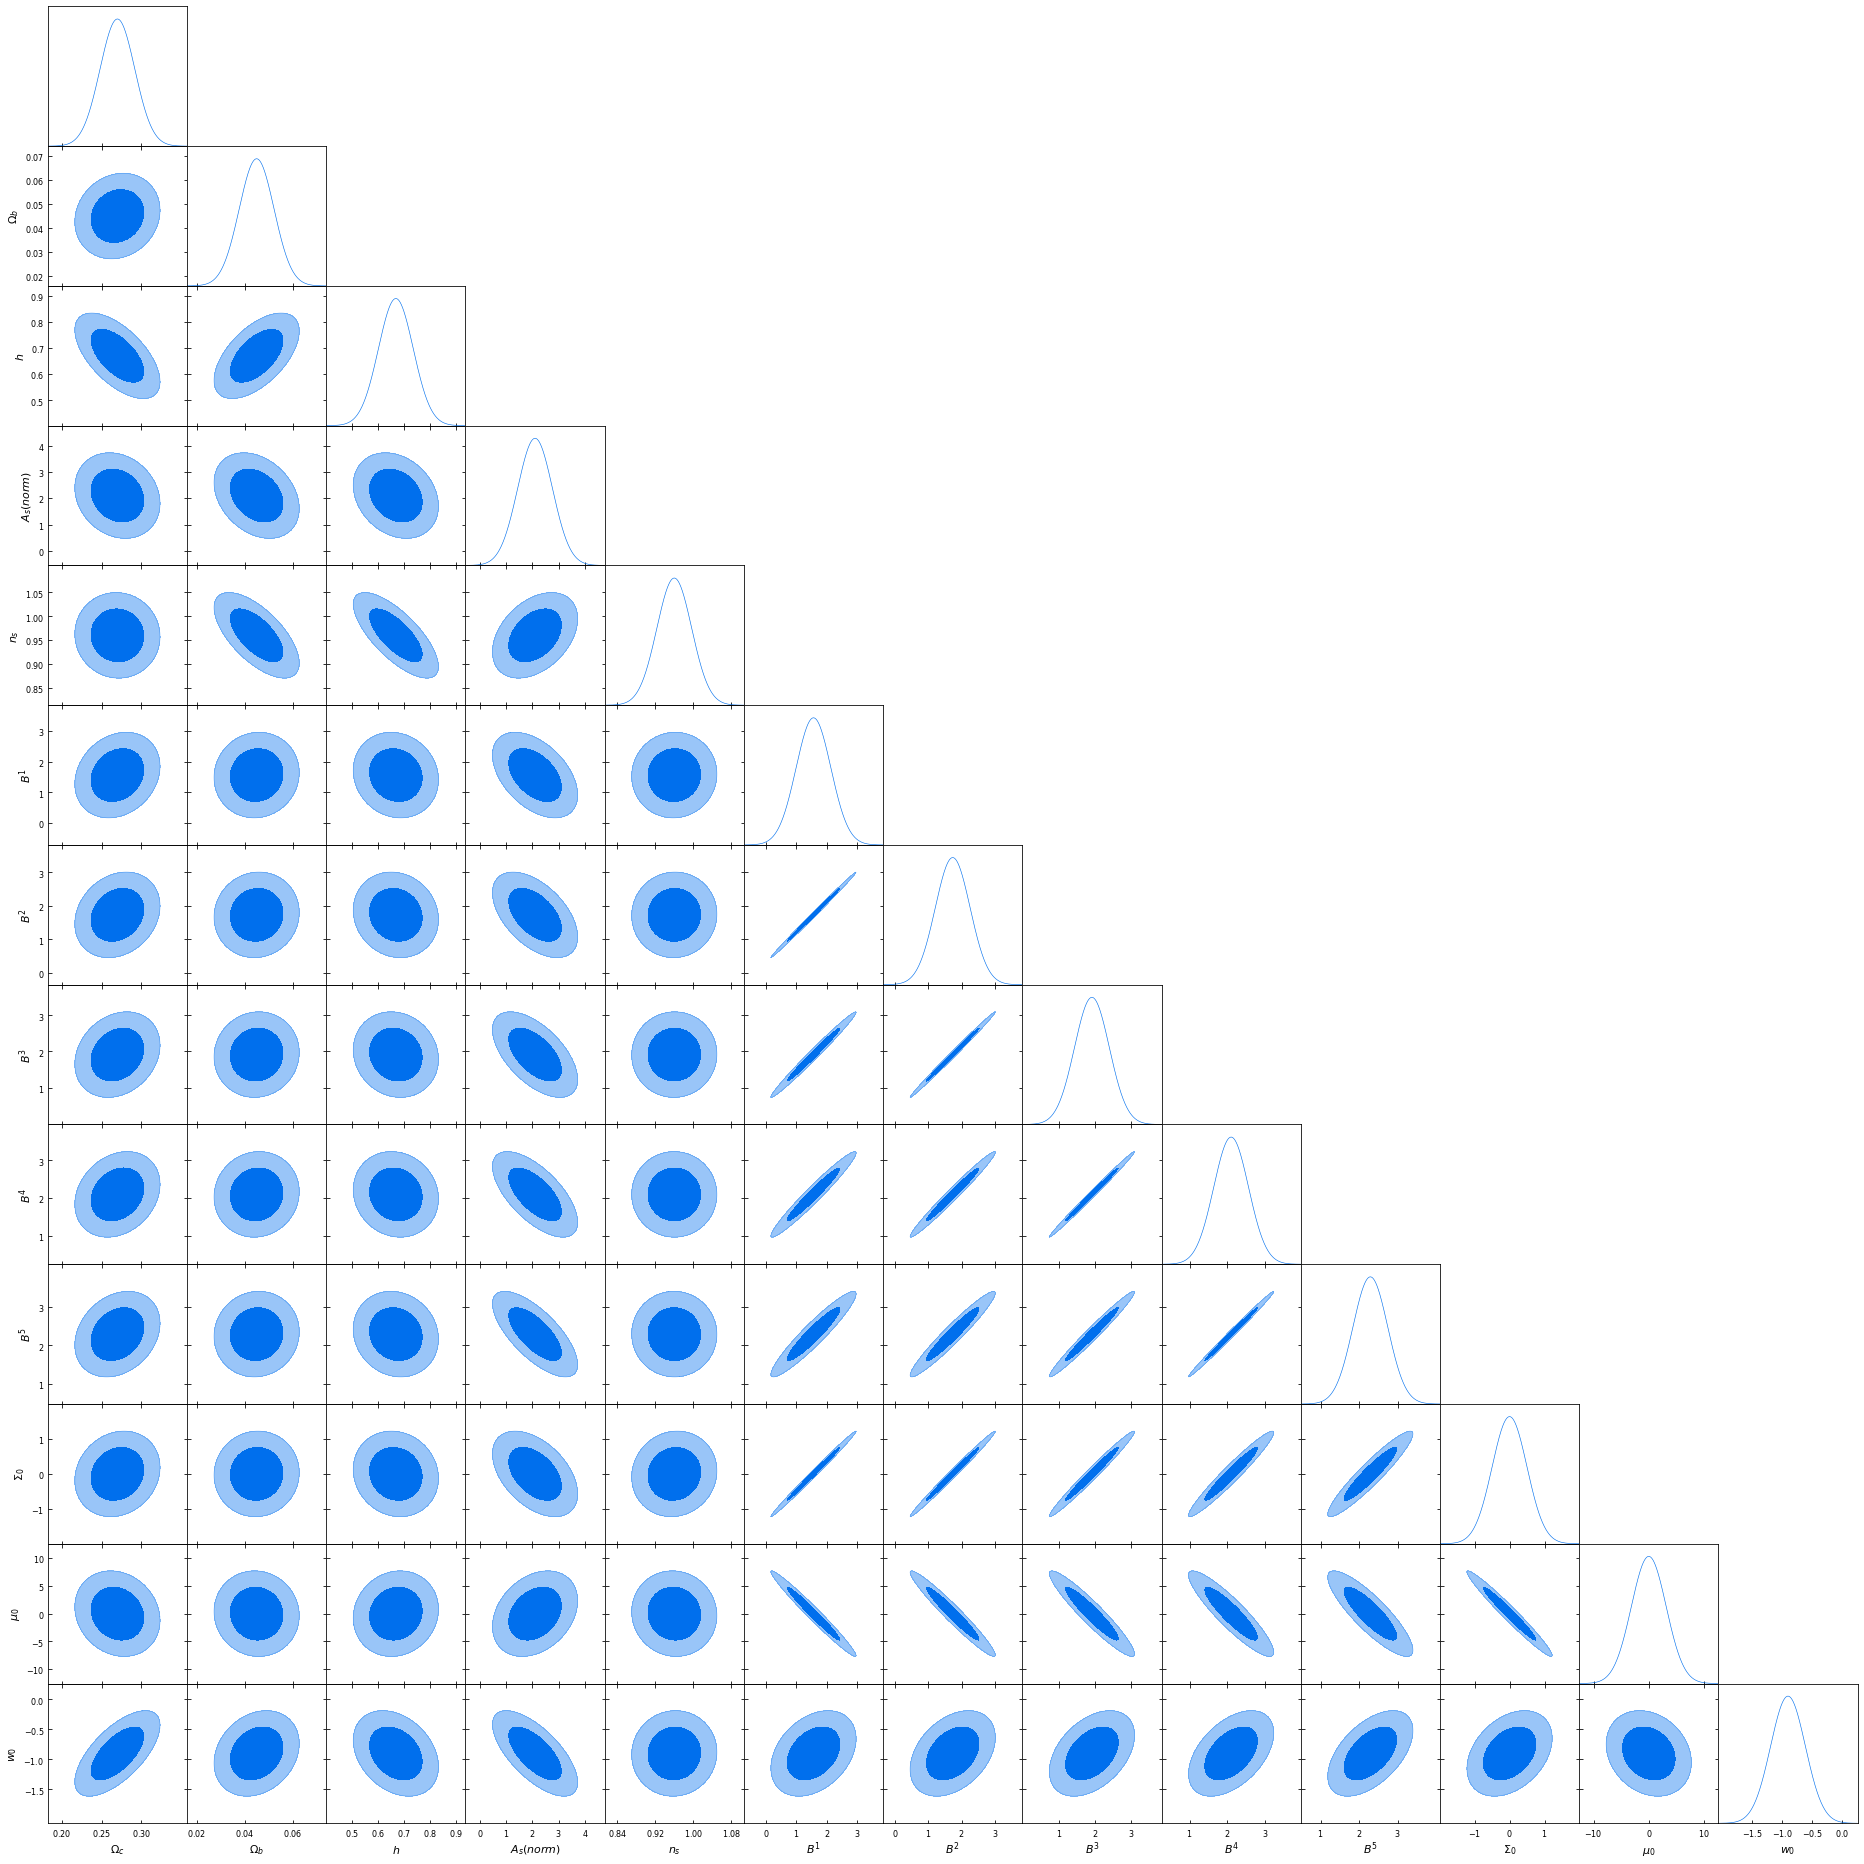

In [81]:
g = plots.get_subplot_plotter()
g.triangle_plot(gauss, filled = True)

In [82]:
param_cov_cleaned_1 = np.delete(param_cov, 5, 0)
param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 1)

param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 0)
param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 1)

param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 0)
param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 1)

param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 0)
param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 1)

param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 0)
param_cov_cleaned_1 = np.delete(param_cov_cleaned_1, 5, 1)

print(np.shape(param_cov_cleaned_1))

(9, 9)


In [83]:
param_mean_cleaned = [0.27, 0.045, 0.67, 2.1, 0.96, 0, 0, -0.9, 0.0]


param_names_cleaned = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s','Sigma_0', 'mu_0', 'w0', 'wa']

labels_cleaned = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'\Sigma_{0}', r'\mu_{0}', r'w_{0}', r'w_{a}']

gauss_cleaned_1 = GaussianND(param_mean_cleaned, param_cov_cleaned_1, labels = labels_cleaned, names = param_names_cleaned)

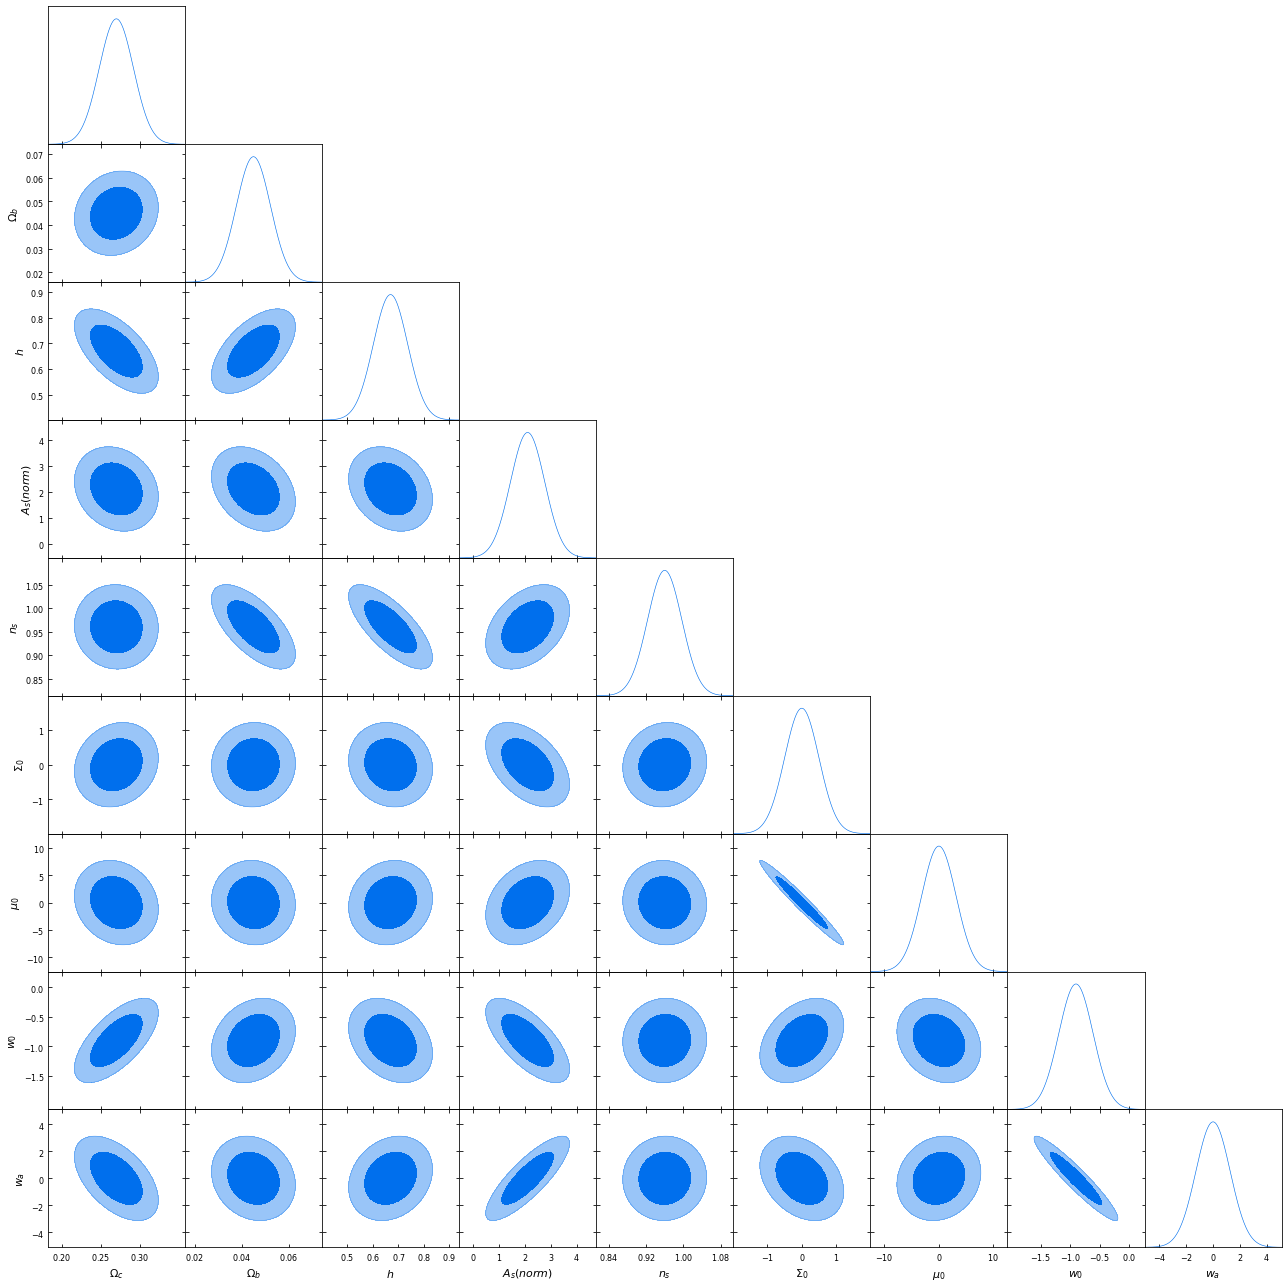

In [84]:
g.triangle_plot(gauss_cleaned_1, filled = True)

In [85]:
param_names_LSST = ['Omega_m', 'sigma8', 'n_s', 'w0', 'wa', 'omega_b', 'h0']
labels_LSST = [r'\Omega_{m}', r'\sigma_{8}', r'n_{s}', r'w_{0}', r'w_{a}', r'\Omega_{b}', r'h_{0}']
mean_LSST = [0.27, 0.83, 0.96, -0.9, 0.0, 0.0450, 0.67]

gauss_LSST = GaussianND(mean_LSST ,param_cov_LSST_Y1, labels = labels_LSST, names = param_names_LSST)


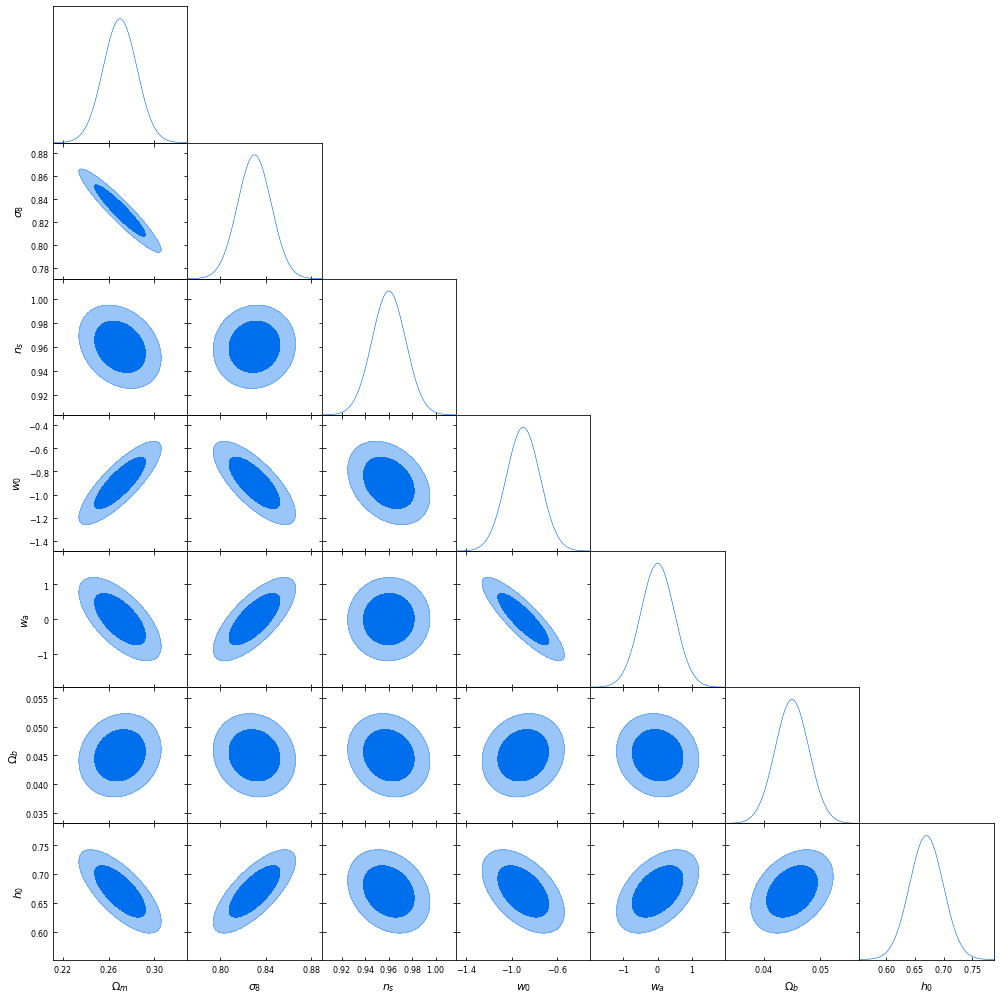

In [86]:
g.triangle_plot(gauss_LSST, filled = True)

In [87]:
#params_fiducial = {'Omega_c': 0.27,\
 #                          'Omega_b': 0.045,\
  #                         'h': 0.67,\
   #                        'A_s_norm': 2.1,\
    #                       'n_s': 0.96,\
     #                      'bias': [1.2, 1.4, 1.6, 1.8, 2.0],\
      #                     'w0': -0.9,\
        #                   'mu_0': 0,\
       #                    'sigma_0': 0 }

param_mean_no_mg = [0.27, 0.045, 0.67, 2.1, 0.96, 1.562362, 1.732963, 1.913252, 2.100644, 2.293210, -0.9, 0.0]


param_names_no_mg = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s', 'B1', 'B2', 'B3', 'B4', 'B5', 'w0', 'wa']

labels_no_mg = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'B^{1}', r'B^{2}', r'B^{3}', r'B^{4}', r'B^{5}', r'w_{0}', r'w_{a}']


gauss_no_mg=GaussianND(param_mean_no_mg, param_cov_no_mg, labels = labels_no_mg, names = param_names_no_mg)

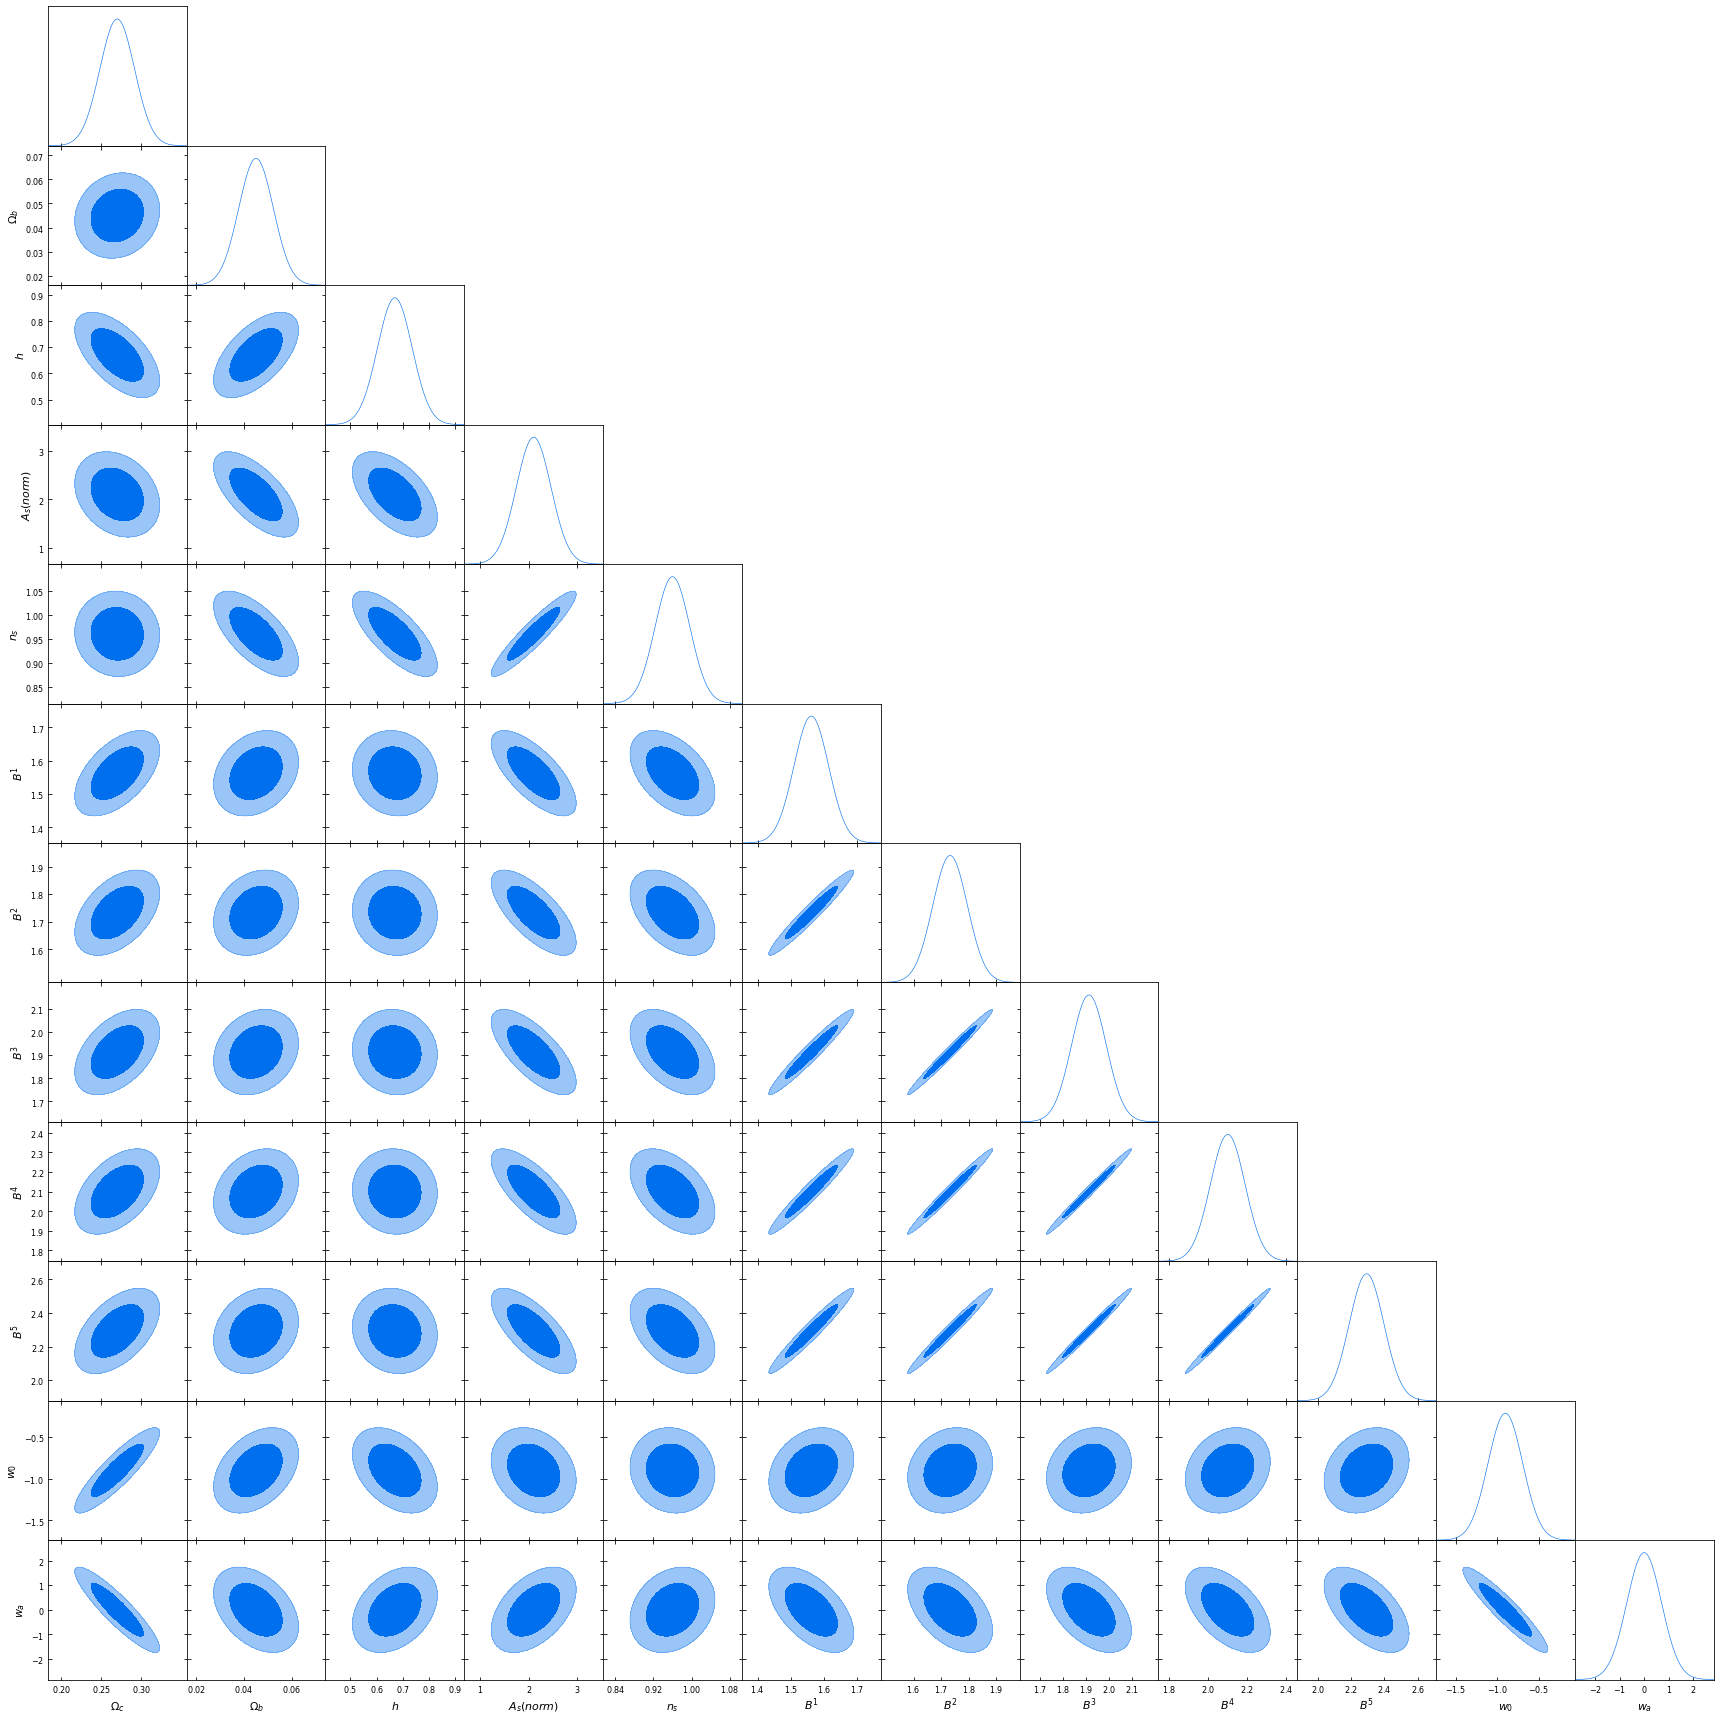

In [88]:
g.triangle_plot(gauss_no_mg, filled = True)

In [42]:
#now clean up the no mg forecast by getting rid of bias constraints
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 0)
param_cov_no_mg_no_bias = np.delete(param_cov_no_mg_no_bias, 5, 1)

print(np.shape(param_cov_no_mg_no_bias))

(7, 7)


In [43]:
param_mean_no_mg_no_bias = [0.27, 0.045, 0.67, 2.1, 0.96, -0.9, 0.0]


param_names_no_mg_no_bias = ['Omega_c', 'Omega_b', 'h', 'A_s_norm', 'n_s', 'w0', 'wa']

labels_no_mg_no_bias = [r'\Omega_{c}', r'\Omega_{b}', r'h', r'A_{s}(norm)', r'n_{s}', r'w_{0}', r'w_{a}']


gauss_no_mg_no_bias = GaussianND(param_mean_no_mg_no_bias,\
                                 param_cov_no_mg_no_bias,\
                                 labels = labels_no_mg_no_bias,\
                                 names = param_names_no_mg_no_bias)

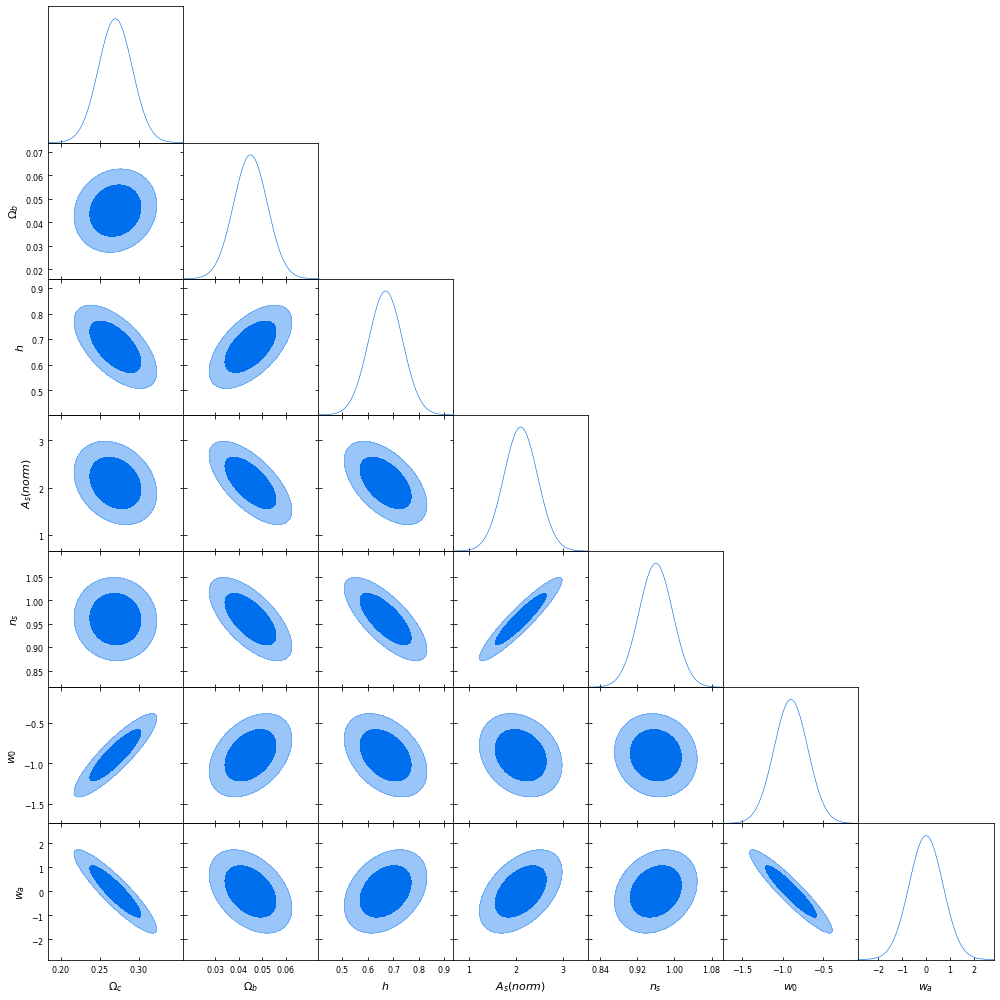

In [44]:
g.triangle_plot(gauss_no_mg_no_bias, filled = True)

In [45]:
#Some test cases for the degenaracy issue with wa-w0
fisher_w_test = np.delete(fisher, 0, 0)
fisher_w_test = np.delete(fisher_w_test, 0, 1)

for i in range(11):
    fisher_w_test = np.delete(fisher_w_test, 0, 0)
    fisher_w_test = np.delete(fisher_w_test, 0, 1)
    
print(np.shape(fisher_w_test))

(2, 2)


In [46]:
param_cov_w = np.linalg.inv(fisher_w_test)

In [47]:
print(param_cov_w)

[[ 0.00018503 -0.00061097]
 [-0.00061097  0.00222086]]


In [48]:
param_mean_w = [-0.9, 0.0]
param_names_w = ['w0', 'wa']
param_labels_w = [r'w_{0}', r'w_{a}']

gauss_w = GaussianND(param_mean_w, param_cov_w, labels = param_labels_w, names = param_names_w)

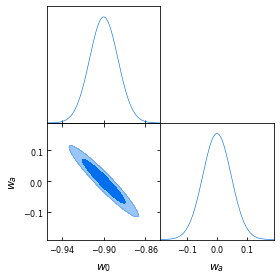

In [49]:
g.triangle_plot(gauss_w, filled = True)

In [89]:
derivatives_2 = [n_s_deriv,\
                 w0_deriv,\
                 wa_deriv,\
                 Omega_b_deriv,\
                 h_deriv,\
                 Omega_c_deriv,\
                 A_s_norm_deriv,\
                 bias_1_deriv,\
                 bias_2_deriv,\
                 bias_3_deriv,\
                 bias_4_deriv,\
                 bias_5_deriv,\
                 sig_0_deriv,\
                 mu_0_deriv]

In [90]:
fisher_LSST_comparison = np.zeros(shape = (14,14))

for i in range(len(derivatives_2)):
    for j in range(len(derivatives_2)):
        fisher_LSST_comparison[i][j] = np.matmul(derivatives_2[i], np.matmul(inv_cov, derivatives_2[j]))
        

In [92]:
param_cov_LSST_comparison = np.linalg.inv(fisher_LSST_comparison)

In [93]:
param_cov_LSST_cleaned = np.delete(param_cov_LSST_Y1, 0, 0)
param_cov_LSST_cleaned = np.delete(param_cov_LSST_cleaned, 0, 1)

param_cov_LSST_cleaned = np.delete(param_cov_LSST_cleaned, 0, 0)
param_cov_LSST_cleaned = np.delete(param_cov_LSST_cleaned, 0, 1)

print(np.shape(param_cov_LSST_cleaned))

(5, 5)


In [94]:
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 0)
param_cov_LSST_comparison = np.delete(param_cov_LSST_comparison, 5, 1)

print(np.shape(param_cov_LSST_comparison))

(5, 5)


In [95]:
param_names_LSST_cleaned = ['n_s', 'w0', 'wa', 'omega_b', 'h0']
labels_LSST_cleaned = [r'n_{s}', r'w_{0}', r'w_{a}', r'\Omega_{b}', r'h_{0}']
mean_LSST_cleaned = [0.96, -0.9, 0.0, 0.0450, 0.67]
mean_LSST_comparison = [0.96, -0.9, 0.0, 0.045, 0.67]

gauss_LSST_cleaned = GaussianND(mean_LSST_cleaned, param_cov_LSST_cleaned, labels = labels_LSST_cleaned, names = param_names_LSST_cleaned)
gauss_LSST_comparison = GaussianND(mean_LSST_comparison, param_cov_LSST_comparison,  labels = labels_LSST_cleaned, names = param_names_LSST_cleaned )

contours = [gauss_LSST_cleaned, gauss_LSST_comparison]

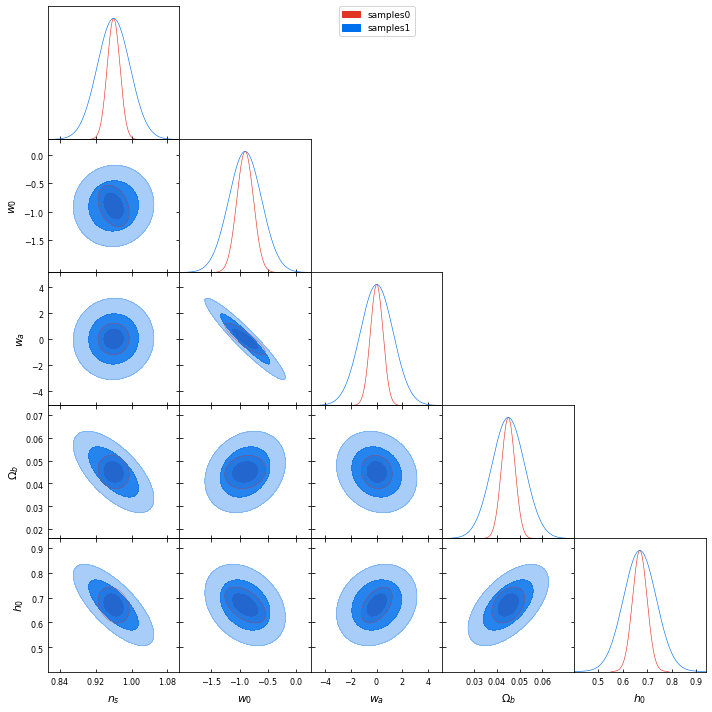

In [99]:
g.triangle_plot(contours, filled = True)

#This contour comparison is from the full parameter fisher matrix (modified gravity as well)
#at current the calculated constraint forecasts are a quite a bit larger than the constraints forecasted by the SRD analysis